In [3]:
import numpy as np
import pandas as pd
import qml
import scipy.spatial as scs
import glob
import scipy.interpolate as sci
import functools
import matplotlib.pyplot as plt
%load_ext line_profiler
c = qml.Compound('../../test/c20.xyz')
from pymatgen.symmetry import analyzer as psa
from pymatgen.core import Molecule

In [4]:
def build_cache():
    mol = Molecule(c.nuclear_charges, c.coordinates)
    a = psa.PointGroupAnalyzer(mol)
    cache = []
    for symop in a.get_symmetry_operations():
        newcoord = symop.operate_multi(c.coordinates)
        ds = scs.distance.cdist(c.coordinates, newcoord)
        f, t = np.where(np.round(ds, 2) == 0.)
        cache.append(t)
    return cache
def get_rotation_single(origin, target):
    return ROTCACHE[ROTCACHE[:, target] == origin][0]
def get_rotation_pair(origin1, origin2, target1, target2):
    return ROTCACHE[(ROTCACHE[:, target1] == origin1) & (ROTCACHE[:, target2] == origin2)][0]

In [13]:
def get_nucnuc(zs):
    ds = scs.distance.squareform(scs.distance.pdist(c.coordinates))*1.8897259885789
    q = np.outer(zs, zs)/ds
    np.fill_diagonal(q, 0)
    return q.sum()/2
def coefficient_matrix(coords=None):
    if coords is None:
        coords = c.coordinates
    result = np.zeros((20, 13))
    lastgrid = None
    lastweights = None
    for fidx, fn in enumerate(FNS):
        _, a, b = read_DENSITY_cached(fn)
        if lastgrid is not None:
            assert np.allclose(_, lastgrid)
            assert np.allclose(a, lastweights)
        lastgrid = _
        lastweights=a
        for j in range(20):
            ds = 1/(np.linalg.norm(_*1.8897259885789 - coords[j]*1.8897259885789, axis=1))/1.8897259885789
            #ds = get_grid_ds(j)/1.8897259885789
            result[j, fidx] = (a*b*ds).sum()
    return result
FNS = '''c20-data/derivatives/order-0/site-all-cc/DENSITY
c20-data/derivatives/order-1/site-0-dn/DENSITY
c20-data/derivatives/order-1/site-0-up/DENSITY
c20-data/derivatives/order-2/site-0-1-dn/DENSITY
c20-data/derivatives/order-2/site-0-1-up/DENSITY
c20-data/derivatives/order-2/site-0-10-dn/DENSITY
c20-data/derivatives/order-2/site-0-10-up/DENSITY
c20-data/derivatives/order-2/site-0-16-dn/DENSITY
c20-data/derivatives/order-2/site-0-16-up/DENSITY
c20-data/derivatives/order-2/site-0-2-dn/DENSITY
c20-data/derivatives/order-2/site-0-2-up/DENSITY
c20-data/derivatives/order-2/site-0-8-dn/DENSITY
c20-data/derivatives/order-2/site-0-8-up/DENSITY'''.split('\n')
def symbolic_read_density(fn):
    return FNS.index(fn)
@functools.lru_cache(maxsize=20*20)
def symbolic_get_deriv(i, j):
    """ Returns 
    t_i : atom index of i after rotation
    t_j : atom index of j after rotation
    deriv_pair : the density to be integrated after pairwise rotation
    deriv_single : density to be integrated after single rotation """
    
    if i != j:
        d = np.linalg.norm(c.coordinates[i] - c.coordinates[j])
        geo = np.argmin(np.abs(np.array(sorted(set(np.round(scs.distance.pdist(c.coordinates), 2)))) - d))
        sites = (0, (1, 2, 8, 10, 16)[geo])
        i, j = sites
    delta = 0.05
    deriv_single = np.zeros(13)
    deriv_pair = np.zeros(13)
    
    mid = symbolic_read_density('c20-data/derivatives/order-0/site-all-cc/DENSITY')
    iup = symbolic_read_density('c20-data/derivatives/order-1/site-0-up/DENSITY')
    idn = symbolic_read_density('c20-data/derivatives/order-1/site-0-dn/DENSITY')
    if i == j:
        deriv_single[iup] = 1/(delta**2)
        deriv_single[idn] = 1/(delta**2)
        deriv_single[mid] = -2/(delta**2)
    else:
        jup = iup
        jdn = idn
        up = symbolic_read_density('c20-data/derivatives/order-2/site-0-%d-up/DENSITY' % j)
        dn = symbolic_read_density('c20-data/derivatives/order-2/site-0-%d-dn/DENSITY' % j)
        
        deriv_pair[up] = 1/ (2 * delta**2)
        deriv_pair[dn] = 1/ (2 * delta**2)
        deriv_pair[mid] = 2/ (2 * delta**2)
        deriv_pair[iup] = -1/ (2 * delta**2)
        deriv_pair[idn] = -1/ (2 * delta**2)
        
        deriv_single[jup] = -1/ (2 * delta**2)
        deriv_single[jdn] = -1/ (2 * delta**2)
    
    return i, j, deriv_pair/6, deriv_single/6
def symbolic_read_grid_first_order():
    changed_site = 0
    delta = 0.05
    
    up = symbolic_read_density('c20-data/derivatives/order-1/site-0-up/DENSITY')
    dn = symbolic_read_density('c20-data/derivatives/order-1/site-0-dn/DENSITY')
    deriv_single = np.zeros(13)
    deriv_single[up] = 1/(2*delta)
    deriv_single[dn] = -1/(2*delta)
    
    return changed_site, deriv_single/2
def read_grid_first_order():
    changed_site = 0
    delta = 0.1
    
    upgrid, upweight, updens = read_DENSITY_cached('c20-data/derivatives/order-1/site-0-up/DENSITY')
    dngrid, dnweight, dndens = read_DENSITY_cached('c20-data/derivatives/order-1/site-0-dn/DENSITY')
    
    if not np.allclose(upgrid, dngrid):
        raise ValueError('Grid?')
        
    if not np.allclose(upweight, dnweight):
        raise ValueError('Grid?')
    
    return changed_site, upgrid, ((updens - dndens) / delta)*upweight
def read_DENSITY(fn):
    with open(fn, 'r') as fh:
        _ = np.fromfile(fh, 'i4')
        q = _[3:-1].view(np.float64)
        ccdensity = q.reshape((-1, 10))
    ccdensity = ccdensity[:, 1:6]
    return ccdensity[:, :3]/1.8897259885789, ccdensity[:, 3], ccdensity[:, 4]
def read_CCSD():
    res = []
    atomE = {'5': -24.561351362788, '6': -37.714812342283, '7': -54.418867578066}
    for fn in glob.glob('validation/CCSD/*/run.log'):
        with open(fn) as fh:
            lines = fh.readlines()[::-1]
            for line in lines:
                if line.startswith(' Total CCSD energy [au]:'):
                    energy = float(line.strip().split()[-1])
                    target = fn.split('/')[-2]
                    atomisation = energy - sum([atomE[_] for _ in target])
                    res.append({'target': target, 'CCSD': energy, 'CCSDatom': atomisation})
                    break
    return pd.DataFrame(res)
df_ccsd = read_CCSD()

In [14]:
@functools.lru_cache(maxsize=20*20*20*20)
def build_reindexing_2_cached(a, b, c, d):
    return build_reindexing_2_merged(a, b, c,d)
@functools.lru_cache(maxsize=20*20*20*20)
def build_reindexing_1_cached(a, b):
    return build_reindexing_1_merged(a, b)
@functools.lru_cache(200)
def read_DENSITY_cached(fn):
    return read_DENSITY(fn)
@functools.lru_cache(30)
def get_grid_ds(j):
    return 1/(np.linalg.norm(grid_points*1.8897259885789 - c.coordinates[j]*1.8897259885789, axis=1))
@functools.lru_cache(maxsize=20*20)
def get_deriv_cached(i, j):
    return get_deriv(i, j)
changed_site, grid_points, grid_densweight = read_grid_first_order()
ROTCACHE = np.array(build_cache())
def symmetrize_coefficients(mat):
    def get_partial_nn(zs):
        ds = scs.distance.squareform(scs.distance.pdist(c.coordinates))
        q = np.outer(zs, zs)/ds
        np.fill_diagonal(q, 0)
        return q.sum(axis=0)
    def partial_update(mat, zs, fidx):
        vals = np.round(get_partial_nn(zs), 2)
        unique = set(vals)
        for u in unique:
            selection = np.where(vals==u)[0]
            #print (mat[selection, fidx].std() / mat[selection, fidx].mean())
            mat[selection, fidx] = mat[selection, fidx].mean()
        return mat
    mat = mat.copy()
    FNS = '''c20-data/derivatives/order-0/site-all-cc/DENSITY
c20-data/derivatives/order-1/site-0-dn/DENSITY
c20-data/derivatives/order-1/site-0-up/DENSITY
c20-data/derivatives/order-2/site-0-1-dn/DENSITY
c20-data/derivatives/order-2/site-0-1-up/DENSITY
c20-data/derivatives/order-2/site-0-10-dn/DENSITY
c20-data/derivatives/order-2/site-0-10-up/DENSITY
c20-data/derivatives/order-2/site-0-16-dn/DENSITY
c20-data/derivatives/order-2/site-0-16-up/DENSITY
c20-data/derivatives/order-2/site-0-2-dn/DENSITY
c20-data/derivatives/order-2/site-0-2-up/DENSITY
c20-data/derivatives/order-2/site-0-8-dn/DENSITY
c20-data/derivatives/order-2/site-0-8-up/DENSITY'''.split('\n')
    #mat = partial_update(mat, [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 0)
    mat = partial_update(mat, [5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 1)
    mat = partial_update(mat, [7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 2)
    mat = partial_update(mat, [5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 3)
    mat = partial_update(mat, [7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 4)
    mat = partial_update(mat, [5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6], 5)
    mat = partial_update(mat, [7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6], 6)
    mat = partial_update(mat, [5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6], 7)
    mat = partial_update(mat, [7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6], 8)
    mat = partial_update(mat, [5, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 9)
    mat = partial_update(mat, [7, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 10)
    mat = partial_update(mat, [5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 11)
    mat = partial_update(mat, [7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 12)
    return mat
#COEFFMAT = symmetrize_coefficients(coefficient_matrix())
COEFFMAT = coefficient_matrix()

In [26]:
def symbolic_get_predictions(comb):
    result = {}
    result['ref'] = -758.072029908548
    
    deltaZ = np.array(comb) - 6
        
    zs = np.array([int(_) for _ in comb])
    zsref = np.zeros(20) + 6
    result['deltaNN'] = get_nucnuc(zs) - get_nucnuc(zsref)
    
    # collect terms to evaluate, shape (density x atoms)
    coefficients = np.zeros((20, 13))
    
    # 0-th order, no rotation necessary, should be hard zero, might not be due to asymmetry
    zero_coefficients = np.zeros(13)
    zero_coefficients[0] = 1
    result['order0'] = np.multiply(np.outer(deltaZ, zero_coefficients), COEFFMAT).sum()
    
    # 1st order
    changed_site, this_coefficients = symbolic_read_grid_first_order()
    for idx in range(20):
        if deltaZ[idx] != 0:
            mapping = get_rotation_single(idx, changed_site)
            
            #assert (deltaZ[mapping][0] == deltaZ[idx])
            assert (mapping[0] == idx)
            assert abs(get_nucnuc(zs) - get_nucnuc(zs[mapping])) < 1e-3
            
            coefficients -= deltaZ[idx] * np.outer(deltaZ[mapping], this_coefficients)
    
    result['order1'] = np.multiply(coefficients,COEFFMAT).sum()
    
    result['prediction'] = result['ref'] + result['order0'] + result['order1']  + result['deltaNN']
    result['target'] = ''.join([str(_) for _ in comb])
    return result

    # debug
    debugp = []
    debugs = []
    
    # 2nd order
    coefficients = np.zeros((20, 13))
    outercache = np.zeros(coefficients.shape)
    del idx
    for idx_i in range(20):
        if deltaZ[idx_i] != 0:
            for idx_j in range(idx_i, 20):
                if deltaZ[idx_j] != 0:
                    # t_i: target for idx_i after rotation
                    # deriv_pair: part of derivative after pair-mapping
                    # deriv_single: part of derivative after single-mapping
                    t_i, t_j, deriv_pair, deriv_single = symbolic_get_deriv(idx_i, idx_j)
                    if idx_i != idx_j:
                        assert (t_j != 0)

                    # pairwise mapping
                    if idx_i != idx_j:
                        mapping = get_rotation_pair(idx_i, idx_j, t_i, t_j)

                        assert (mapping[t_i] == idx_i)
                        assert (mapping[t_j] == idx_j)
                        assert abs(get_nucnuc(zs) - get_nucnuc(zs[mapping])) < 1e-3
                        
                        np.outer(deltaZ[mapping], deriv_pair, out=outercache)
                        change = -(deltaZ[idx_i] * deltaZ[idx_j]) * outercache
                        debugp.append(np.multiply(change, COEFFMAT).sum())
                        #print (idx_i, idx_j, np.multiply(change, COEFFMAT).sum())
                        coefficients += change*2

                    # single mapping
                    mapping = get_rotation_single(idx_j, 0)
                    assert (deltaZ[mapping][0] != 0)
                    assert abs(get_nucnuc(zs) - get_nucnuc(zs[mapping])) < 1e-3
                    np.outer(deltaZ[mapping], deriv_single, out=outercache)
                    change = -(deltaZ[idx_i] * deltaZ[idx_j]) * outercache
                    if idx_i != idx_j:
                        debugs.append ( np.multiply(change, COEFFMAT).sum())
                        #print (debugs[-1], debugp[-1])
                    coefficients += change 
    
    #result['order2'] = np.multiply(coefficients,COEFFMAT).sum()
    
    result['prediction'] = result['ref'] + result['order0'] + result['order1'] + result['order2']  + result['deltaNN']
    result['target'] = ''.join([str(_) for _ in comb])
    return result
print (symbolic_get_predictions([int(_) for _ in '75666666666666666666']))
print (symbolic_get_predictions([int(_) for _ in '57666666666666666666']))
#print(symbolic_get_predictions([int(_) for _ in '55555555775777777577']))

{'ref': -758.072029908548, 'deltaNN': -0.35417018326938887, 'order0': 0.011611533543252506, 'order1': -0.8534594398587103, 'prediction': -759.2680479981328, 'target': '75666666666666666666'}
{'ref': -758.072029908548, 'deltaNN': -0.35417327457912506, 'order0': -0.011611533543252506, 'order1': -0.8534594398587103, 'prediction': -759.2912741565291, 'target': '57666666666666666666'}


/home/guido/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
def get_predictions_old():
    ret = []
    for val in df_ccsd.target.values[::1]:
        try:
            q = symbolic_get_predictions([int(_) for _ in val])
        except:
            print (val)
            raise
        q['bnpairs'] = len([_ for _ in val if _ =='5'])
        ret.append(q)
    def atomisation(row):
        atomE = {'5': -23.624308208720, '6': -37.714812342283, '7': -52.831420359950}
        a = sum([atomE[_] for _ in row['target']])
        return a
    df = pd.DataFrame(ret)
    df['atomisation'] = df.apply(atomisation, axis=1)
    q = pd.merge(df, df_ccsd, how='inner')
    return q

In [28]:
%time predictions = get_predictions_old()

/home/guido/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


CPU times: user 4.69 s, sys: 31.2 ms, total: 4.72 s
Wall time: 4.82 s


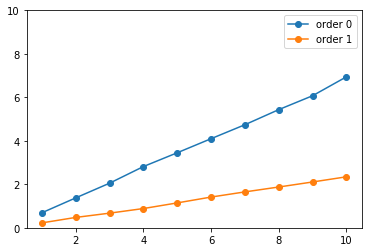

In [24]:
predictions['error'] = abs(predictions.ref + predictions.deltaNN + predictions.order0 - predictions.atomisation - predictions.CCSDatom)
q = predictions.groupby('bnpairs').mean().reset_index()
plt.plot(q.bnpairs, q.error, 'o-', label='order 0')

predictions['error'] = abs(predictions.ref + predictions.deltaNN + predictions.order0+ predictions.order1 - predictions.atomisation - predictions.CCSDatom)
q = predictions.groupby('bnpairs').mean().reset_index()
plt.plot(q.bnpairs, q.error, 'o-', label='order 1')

#predictions['error'] = abs(predictions.ref + predictions.deltaNN + predictions.order0 + predictions.order1 + predictions.order2 - predictions.atomisation - predictions.CCSDatom)
#q = predictions.groupby('bnpairs').mean().reset_index()
#plt.plot(q.bnpairs, q.error, 'o-', label='order 2')

plt.ylim(0, 10)
plt.legend()

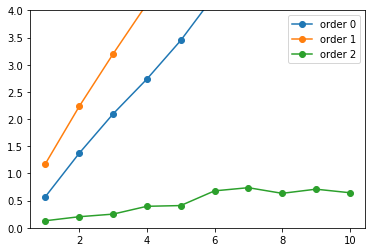

In [272]:
#predictions_old = get_predictions_old()
#predictions_new = predictions

for predictions in (predictions_old,):

    predictions['error'] = abs(predictions.ref + predictions.deltaNN + predictions.order0 - predictions.atomisation - predictions.CCSDatom)
    q = predictions.groupby('bnpairs').mean().reset_index()
    plt.plot(q.bnpairs, q.error, 'o-', label='order 0')

    predictions['error'] = abs(predictions.ref + predictions.deltaNN + predictions.order0+ predictions.order1 - predictions.atomisation - predictions.CCSDatom)
    q = predictions.groupby('bnpairs').mean().reset_index()
    plt.plot(q.bnpairs, q.error, 'o-', label='order 1')

    predictions['error'] = abs(predictions.ref + predictions.deltaNN + predictions.order0 + predictions.order1*0.4 + predictions.order2*0.001 - predictions.atomisation - predictions.CCSDatom)
    q = predictions.groupby('bnpairs').mean().reset_index()
    plt.plot(q.bnpairs, q.error, 'o-', label='order 2')

    plt.ylim(0, 4)
    plt.legend()
    #plt.show()


#symbolic_get_deriv(19, 10)
#1/(0.05**2)/6
#list(enumerate(FNS))

0-up
-2mid
0-dn

08
pair:
0  1  2 3 4 5 6 7 8 9 0 1 2
2 -1 -1                 1 1
single
0 -1 -1 0 0 0 0 0 0 0 0 0 0

In [79]:
# test symmetry
def test_symmetry():
    def do_loop(idx_i, idx_j):
        print ('######## Mapping %d and %d' % (idx_i, idx_j))
        t_i, t_j, deriv_pair, deriv_single = symbolic_get_deriv(idx_i, idx_j)
        print ('After pair rotation: %d -> %d' % (idx_i, t_i))
        print ('After pair rotation: %d -> %d' % (idx_j, t_j))
        
        # pairwise mapping
        cp = 0.
        if idx_i != idx_j:
            mapping = get_rotation_pair(idx_i, idx_j, t_i, t_j)
            print ('NN', get_nucnuc(np.array(comb)[mapping]), get_nucnuc(np.array(comb)))
            print ('Pair mapping:')
            for f, t in zip(mapping, range(20)):
                print (' %d -> %d' % (f, t))
            print ('Pair mapping:', list(mapping))

            print ('Pair derivative combination: ', np.round(deriv_pair, 2))
            print ('Change in Z', deltaZ[mapping])
            outercache = np.outer(deltaZ[mapping], deriv_pair)
            print ('1outer5', list(outercache[[18, 10], 4]))
            change = -(deltaZ[idx_i] * deltaZ[idx_j]) * outercache
            print ('1up5', list(np.multiply(change, COEFFMAT)[[18,10], 4]))
            cp = np.multiply(change, COEFFMAT).sum(axis=0)

        # single mapping
        mapping = get_rotation_single(idx_j, 0)
        outercache = np.outer(deltaZ[mapping], deriv_single)
        change = -(deltaZ[idx_i] * deltaZ[idx_j]) * outercache
        cs = np.multiply(change, COEFFMAT).sum(axis=0)
        
        return cs, cp, cs.sum() + cp.sum()
    
    comb = [int(_) for _ in '55555555775777777577']
    deltaZ = np.array(comb) - 6
    
    print (do_loop(0, 1))
    print (do_loop(1, 0))
test_symmetry()

######## Mapping 0 and 1
After pair rotation: 0 -> 0
After pair rotation: 1 -> 1
NN 1381.052475014788 1381.052475014788
Pair mapping:
 0 -> 0
 1 -> 1
 2 -> 2
 3 -> 3
 4 -> 4
 5 -> 5
 6 -> 6
 7 -> 7
 8 -> 8
 9 -> 9
 10 -> 10
 11 -> 11
 12 -> 12
 13 -> 13
 14 -> 14
 15 -> 15
 16 -> 16
 17 -> 17
 18 -> 18
 19 -> 19
Pair mapping: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Pair derivative combination:  [ 66.67 -33.33 -33.33  33.33  33.33   0.     0.     0.     0.     0.
   0.     0.     0.  ]
Change in Z [-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1  1  1  1 -1  1  1]
1outer5 [33.33333333333333, -33.33333333333333]
1up5 [-664.0187775722002, 664.0187775722002]
(array([ 0.        ,  2.43367093, -2.46172179,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ]), array([ 0.        ,  1.34645788, -1.79975337, -7.25719581,  8.73099224,
        0.        ,  0.        ,  0.        ,  

/home/guido/miniconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [374]:
mol = Molecule(c.nuclear_charges, c.coordinates)
a = psa.PointGroupAnalyzer(mol)
mol2 = a.symmetrize_molecule()['sym_mol']

In [401]:
fwd = np.array([667.08267279153, 667.3409121393335, 665.0338120609457, 665.1726486145393, 663.8493364307346, 662.7079814892338, 664.3397718415877, 665.6376567869784, -662.1457555460362, -665.3019547998745, 662.3313687611204, -664.3399583981189, -665.3136088268443, -662.1081187250829, -665.3014439165112, -663.6217352784826, -665.8011725831825, 666.0756341557446, -664.8083974223536, -665.1990133871308])

In [402]:
bwd = np.array([667.08267279153, 667.3409121393335, 665.0338120609457, 665.1726486145393, 663.8493364307346, 662.7079814892338, 664.3397718415877, 665.6376567869784, -662.1457555460362, -665.3019547998745, -662.3313687611204, -664.3399583981189, -665.3136088268443, -662.1081187250829, -665.3014439165112, -663.6217352784826, 665.8011725831825, -666.0756341557446, 664.8083974223536, -665.1990133871308])

In [409]:
np.round(fwd[[1, 0, 5, 6, 7, 2, 3, 4, 13, 14, 18, 19, 15, 8, 9, 12, 17, 16, 10, 11]] - bwd, 2)

array([ 0.26, -0.26, -2.33, -0.83,  1.79,  2.33,  0.83, -1.79,  0.04,
        0.  , -2.48, -0.86,  1.69, -0.04, -0.  , -1.69,  0.27,  0.27,
       -2.48,  0.86])

In [411]:
0.26, -0.26, 
-2.33, 2.33, 
 -1.79,  1.79, 
-0.83, 0.83, 
0.04, -0.04,
 1.69,-1.69, 
0.  ,  -0.86,   -0.  ,   0.86

 0.27,  0.27,
-2.48,-2.48,

-4.419999999999999

In [443]:
bwd[10]+bwd[18]

2.4770286612331347

In [461]:
mapping = [1, 0, 5, 6, 7, 2, 3, 4, 13, 14, 18, 19, 15, 8, 9, 12, 17, 16, 10, 11]
comb = [int(_) for _ in '55555555775777777577']
deltaZ = np.array(comb) - 6
for f, t in zip(mapping, range(20)):
    if f > t:
        continue
    #if f == 10 or t == 10:
    print (f, t, np.round(fwd[f]- bwd[t], 2), np.round(fwd[t]- bwd[f], 2), np.round(fwd[f]- bwd[t], 2)+ np.round(fwd[t]- bwd[f], 2))
    #    print(deltaZ[[f, t]],deltaZ[[t, f]])

0 1 -0.26 0.26 0.0
2 5 2.33 -2.33 0.0
3 6 0.83 -0.83 0.0
4 7 -1.79 1.79 0.0
8 13 -0.04 0.04 0.0
9 14 -0.0 0.0 0.0
12 15 -1.69 1.69 0.0
16 17 0.27 0.27 0.54
10 18 -2.48 -2.48 -4.96
11 19 0.86 -0.86 0.0


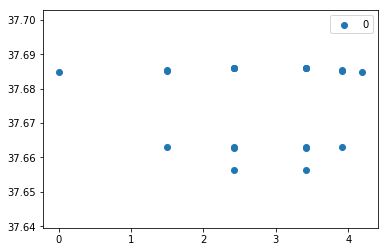

In [168]:
for diff in (0,):
    copy = c.coordinates.copy()
    copy[0, 0] += diff
    ds = scs.distance.squareform(scs.distance.pdist(c.coordinates))
    nval = 0
    comat = coefficient_matrix(copy
    plt.scatter(ds[:, 0], comat[:, nval], label=diff)
plt.legend()

In [97]:
def symmetrize_coefficients(mat):
    def get_partial_nn(zs):
        ds = scs.distance.squareform(scs.distance.pdist(c.coordinates))
        q = np.outer(zs, zs)/ds
        np.fill_diagonal(q, 0)
        return q.sum(axis=0)
    def partial_update(mat, zs, fidx):
        vals = np.round(get_partial_nn(zs), 2)
        unique = set(vals)
        for u in unique:
            selection = np.where(vals==u)[0]
            #print (mat[selection, fidx].std() / mat[selection, fidx].mean())
            mat[selection, fidx] = mat[selection, fidx].min()
        return mat
    mat = mat.copy()
    FNS = '''c20-data/derivatives/order-0/site-all-cc/DENSITY
c20-data/derivatives/order-1/site-0-dn/DENSITY
c20-data/derivatives/order-1/site-0-up/DENSITY
c20-data/derivatives/order-2/site-0-1-dn/DENSITY
c20-data/derivatives/order-2/site-0-1-up/DENSITY
c20-data/derivatives/order-2/site-0-10-dn/DENSITY
c20-data/derivatives/order-2/site-0-10-up/DENSITY
c20-data/derivatives/order-2/site-0-16-dn/DENSITY
c20-data/derivatives/order-2/site-0-16-up/DENSITY
c20-data/derivatives/order-2/site-0-2-dn/DENSITY
c20-data/derivatives/order-2/site-0-2-up/DENSITY
c20-data/derivatives/order-2/site-0-8-dn/DENSITY
c20-data/derivatives/order-2/site-0-8-up/DENSITY'''.split('\n')
    #mat = partial_update(mat, [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 0)
    mat[:, 0] = mat[0, 0]
    mat = partial_update(mat, [5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 1)
    mat = partial_update(mat, [7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 2)
    mat = partial_update(mat, [5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 3)
    mat = partial_update(mat, [7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 4)
    mat = partial_update(mat, [5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6], 5)
    mat = partial_update(mat, [7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6], 6)
    mat = partial_update(mat, [5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6], 7)
    mat = partial_update(mat, [7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6], 8)
    mat = partial_update(mat, [5, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 9)
    mat = partial_update(mat, [7, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 10)
    mat = partial_update(mat, [5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 11)
    mat = partial_update(mat, [7, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 12)
    return mat

In [44]:
# try rectangular grid remapping
grid_x, grid_y, grid_z = np.mgrid[-5:5:20j, -5:5:20j, -5:5:20j]
from scipy.interpolate import griddata
points, weights, dens = read_DENSITY_cached('c20-data/derivatives/order-2/site-0-1-up/DENSITY')
newrho = griddata(points, dens, (grid_x, grid_y, grid_z), method='nearest')
newrho *= 120/newrho.sum()

In [45]:
coeffs = np.zeros(20)
for aidx in range(20):
    ds = 1/(np.linalg.norm(np.vstack((grid_x.ravel(), grid_y.ravel(),grid_z.ravel())).T*1.8897259885789 - c.coordinates[aidx]*1.8897259885789, axis=1))
    coeffs[aidx] = (newrho.ravel() * ds).sum()

[1.49412617 1.49412617 3.91167308 4.83509384 3.91167308 3.91167103
 4.8350915  3.911672   5.83647242 5.8364726  7.33059843 6.83785346
 7.33059878 5.83646985 5.83647033 7.33059914 8.09898463 8.09898498
 7.33059892 6.83785368]


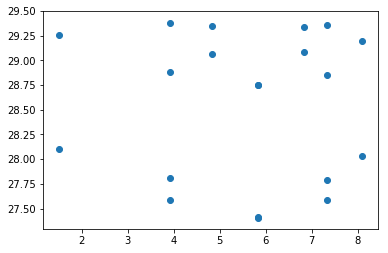

In [47]:
ds = scs.distance.squareform(scs.distance.pdist(c.coordinates))
plt.scatter(ds[:, 0]+ds[:, 1], coeffs)
print (ds[:, 0]+ds[:, 1])

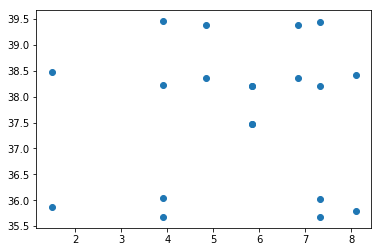

In [39]:
ds = scs.distance.squareform(scs.distance.pdist(c.coordinates))
plt.scatter(ds[:, 0]+ds[:, 1], coeffs)

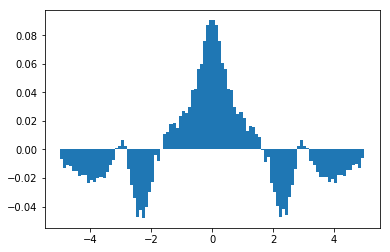

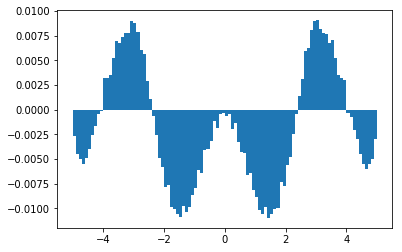

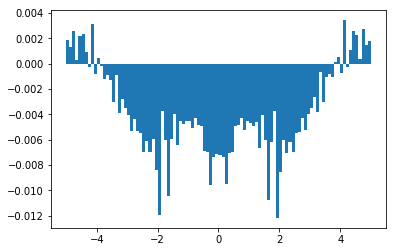

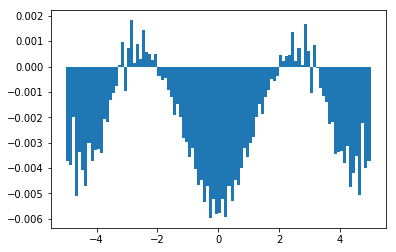

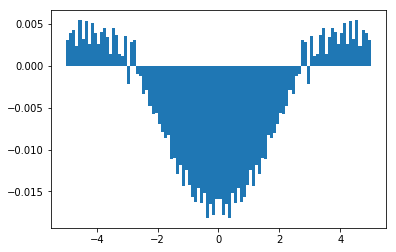

In [140]:
for pairsite in (1, 2,8,10,16):
    points1, weights1, dens1 = read_DENSITY_cached('c20-data/derivatives/order-2/site-0-%d-up/DENSITY' % pairsite)
    points2, weights2, dens2 = read_DENSITY_cached('c20-data/derivatives/order-2/site-0-%d-dn/DENSITY' % pairsite)
    axis = c.coordinates[pairsite] - c.coordinates[0]
    pxs = np.dot(points1, axis)
    _ = plt.hist(pxs, weights=(dens1*weights1-dens2*weights2), bins=100, range=(-5, 5))
    plt.show()

In [165]:
(dens*np.linalg.norm(points - points.mean(axis=0), axis=1)).sum() / np.sum(dens)

2.093887942406835

In [163]:
np.linalg.norm(c.coordinates - c.coordinates.mean(axis=0), axis=1).mean()

2.0936565688710975

In [2]:
# predict all rotations, then average
def rotational_averaged_predictions(base):
    base = np.array(base)
    ps = []
    for rotation in range(120):
        comb = base[ROTCACHE[ rotation, :]]
        ps.append(symbolic_get_predictions(comb))
    pdf = pd.DataFrame(ps)
    return pdf
    q = pdf.mean().to_dict()
    q['target'] = ''.join([str(int(_)) for _ in base])
    q['prediction'] = q['ref'] + q['deltaNN'] + q['order0'] + q['order1'] + q['order2']
    return q
rotational_averaged_predictions([int(_) for _ in '55555555775777777577'])

NameError: name 'np' is not defined

In [1]:
pdf

NameError: name 'pdf' is not defined

In [34]:
predictions['APDFT0_T'] = predictions.ref + predictions.order0 + predictions.deltaNN
predictions['APDFT1_T'] = predictions.ref + predictions.order0 + predictions.deltaNN + predictions.order1
predictions['target APDFT0_T APDFT1_T'.split()].to_csv('validation/APDFT.csv')